In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import requests

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

global_dict = json.loads(requests.get('https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json').text)
local_dict = json.loads(requests.get('https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json').text)
#--#
url = 'https://raw.githubusercontent.com/guebin/DV2022/main/posts/Energy/{}.csv'
prov = ['Seoul', 'Busan', 'Daegu', 'Incheon', 
        'Gwangju', 'Daejeon', 'Ulsan', 'Sejongsi', 
        'Gyeonggi-do', 'Gangwon-do', 'Chungcheongbuk-do', 
        'Chungcheongnam-do', 'Jeollabuk-do', 'Jeollanam-do', 
        'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do']
df = pd.concat([pd.read_csv(url.format(p+y)).assign(년도=y, 시도=p) for p in prov for y in ['2018', '2019', '2020', '2021']]).reset_index(drop=True)\
.assign(년도 = lambda df: df.년도.astype(int))\
.set_index(['년도','시도','지역']).applymap(lambda x: int(str(x).replace(',','')))\
.reset_index()
df_global = pd.DataFrame([l['properties'] for l in global_dict['features']])
df_local = pd.DataFrame([l['properties'] for l in local_dict['features']])
df_json = df_local.set_index('name')\
.rename(
    {name:name.split('시')[-1] for name in df_local['name'] if ('시' in name) and ('구' in name) and (len(name)>3)}
).reset_index()\
.drop(['base_year','name_eng'],axis=1)\
.rename({'name':'name_local','code':'code_local'},axis=1)\
.assign(code = lambda df: df['code_local'].str[:2])\
.merge(df_global.drop(['base_year','name_eng'],axis=1))
df_left = df.assign(
    시도 = lambda df: df.시도.map({l['properties']['name_eng']:l['properties']['name'] for l in global_dict['features']})
).assign(on = lambda df: df.시도 + '-' + df.지역)
df_right = df_json.assign(on = lambda df: df.name + '-' + df.name_local)\
.drop(['name_local','name'],axis=1)
df2 = df_left.merge(
    df_right.set_index('on')\
    .rename({'인천광역시-남구':'인천광역시-미추홀구'})\
    .reset_index()
).drop(['on'],axis=1)

/tmp/ipykernel_356/1516935476.py:22: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [5]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 10.3 MB/s eta 0:00:00


In [9]:
#| title: 에너지사용량 자료 
import itables 
itables.show(df2,showIndex=False)

In [ ]:
#| title: 2018년도 전기사용량 (전국)
fig = px.choropleth_mapbox(
    geojson = local_dict,
    featureidkey = 'properties.code',
    data_frame = df2.query('년도 == 2018'),
    locations = 'code_local',
    color = '에너지사용량(TOE)/전기',
    hover_data = ['시도','지역'],
    #---#
    mapbox_style="carto-positron",
    range_color = [0,200000],
    center={"lat": 36, "lon": 127.5}, 
    zoom=6,
)
fig.show(config={'scrollZoom':False})

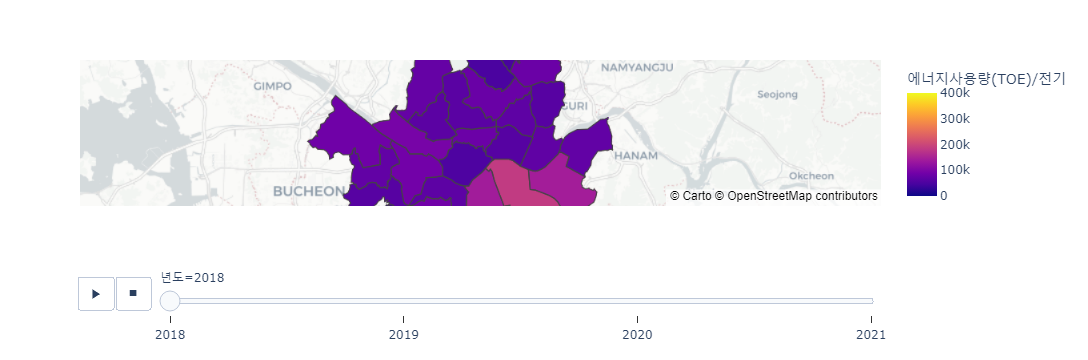

In [6]:
#| title: 2018~2019년도 전기사용량 (서울)
seoul_dict = local_dict.copy() 
seoul_dict['features'] = [l for l in seoul_dict['features'] if l['properties']['code'][:2] == '11']
fig = px.choropleth_mapbox(
    geojson = seoul_dict,
    featureidkey = 'properties.code',
    data_frame = df2,
    locations = 'code_local',
    color = '에너지사용량(TOE)/전기',
    animation_frame= '년도',
    hover_data = ['시도','지역'],
    #---#
    mapbox_style="carto-positron",
    range_color = [0,400000],
    center={"lat": 37.5642135, "lon": 127.0016985},
    zoom=9,
)
fig.show(config={'scrollZoom':False})

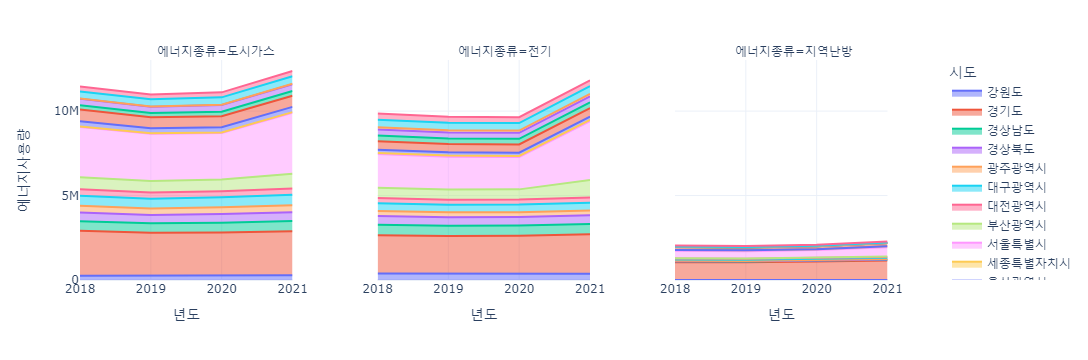

In [8]:
#| title: 2018~2019년도 에너지사용량 (전국)
fig = df2.drop(['code_local','code'],axis=1)\
.set_index(['년도','시도','지역','건물동수','연면적']).stack().reset_index()\
.rename({'level_5':'에너지종류', 0:'에너지사용량'},axis=1)\
.assign(에너지종류 = lambda df: df['에너지종류'].str.split('/').str[-1])\
.groupby(['년도','시도','에너지종류']).agg({'에너지사용량':'sum'})\
.stack().reset_index()\
.rename({0:'에너지사용량'},axis=1)\
.plot.area(
    x='년도',y='에너지사용량',
    color='시도',
    facet_col='에너지종류'
)
fig.update_layout(
    xaxis_domain=[0.0, 0.25],
    xaxis2_domain=[0.35, 0.60],
    xaxis3_domain=[0.70, 0.95]
)